# Project 2: Continuous Control

In this notebook, I will train a DDPG model using Unity ML environment for the second project of the Deep Reinforcement Learning Nanodegree (https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)


## 1. Imports


In [16]:
import os
import sys
import platform
from collections import namedtuple,deque
import random
import copy
import pickle
from unityagents import UnityEnvironment
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 2. Agent and deep nets parameters

In [2]:
BUFFER_SIZE = 100000      # replay buffer size
BATCH_SIZE = 128          # minibatch size
GAMMA = 0.99              # discount factor
TAU = 0.001               # for soft update of target parameters
LR_ACTOR = 0.0001         # learning rate of the actor
LR_CRITIC = 0.0001        # learning rate of the critic
WEIGHT_DECAY = 0          # L2 weight decay
UPDATE_EVERY = 10000
#epsilon greedy params for exploration vs exploatation
EPS_START=1.0
EPS_END=0.05
EPS_DECAY=3e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 3. Definitions for actor and critic neural nets

Helper function

In [3]:
def hidden_init(layer):
    # source: The other layers were initialized from uniform distributions
    # [− 1/sqrt(f) , 1/sqrt(f) ] where f is the fan-in of the layer
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

Define the Actor and Critic classes

In [4]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=256,
                 fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.elu(self.fc1(state)) # somehow elu works better than relu
        x = F.elu(self.fc2(x))
        return torch.tanh(self.fc3(x))

In [5]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=256,
                 fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action.float()), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)


Helper class - the replay buffer ( storing experiences for training )

In [6]:
class ReplayBuffer(object):
    '''
    Fixed-size buffer to store experience tuples
    '''

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward",
                                                  "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences
                                  if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences
                                   if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences
                                   if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state
                                                  for e in experiences
                                                  if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences
                                            if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


Helper class - speciffic noise

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state


The ddpg agent

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        #self.noise = OUNoise(action_size, random_seed) #single agent only
        self.noise = OUNoise((num_agents, action_size), random_seed) #both singe and multiple agent
        self.eps = EPS_START

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
        # Make sure target is initialized with the same weight as the source (found on slack to make big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for a in range(self.num_agents):
            self.memory.add(states[a], actions[a], rewards[a], next_states[a], dones[a])

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise according to epsilon probability
        if add_noise and (np.random.random() < self.eps):
            actions += self.noise.sample()
            #update the exploration parameter
            self.eps -= EPS_DECAY
            if self.eps < EPS_END:
                self.eps = EPS_END
            
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #clip the gradient for the critic network - hint in Udacity project description
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) 
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


    ## from slack - improves learning a lot
    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)



## 4. Exploring the Environment

In [9]:
env = UnityEnvironment(file_name='./Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Let's check some information about the environment below.

In [10]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents, env_info.vector_observations.shape[0])

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 5. Training function

Now, we are going to train the agent for 1000 episodes or until it reaches an average score of 30 over the last 100 episodes and over the 20 agents. 

In [11]:
def train_agent(episodes=2000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    prev_scores = 0
    for episode in range(episodes):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations                 
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          
        while True:                                            # training loop
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            
            agent.step(states, actions, rewards, next_states, dones) #train the agent

            # In the ramp up phase we do some extra learning per time step 
            # (since generating so much experience at each step)
            # Once it reaches an acceptable value of scoring
            # we train more lightly
            if prev_scores < 33:
                if len(agent.memory) > BATCH_SIZE:
                    for i in range(3):
                        experiences = agent.memory.sample()
                        agent.learn(experiences, GAMMA)
            else:
                if episode%UPDATE_EVERY == 0 and len(agent.memory)>BATCH_SIZE:
                    experiences = agent.memory.sample()
                    agent.learn(experiences,GAMMA)
            
            states = next_states                               
            if np.any(dones):                                  # exit loop if episode finished
                break
            
        episode_mean = np.mean(scores)
        scores_deque.append(episode_mean)
        scores_list.append(np.mean(episode_mean))
        prev_scores = episode_mean
        print('Episode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, np.mean(scores_deque), episode_mean))
        
        #stop condition, average greater than 30 over 100 episodes
        if np.mean(scores_deque) > 30 and len(scores_deque) >= 100:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('Solved')
            break
            
    return scores_list

## 6. Run training
We train the agent for 1000 episodes or until it reaches an average score of 30 over the last 100 episodes and over the 20 agents, as requested in project requirements

In [12]:
agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)



scores = train_agent()



/Users/nutz/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 1	Average Score: 0.63	Score: 0.63
Episode 2	Average Score: 0.69	Score: 0.74
Episode 3	Average Score: 1.01	Score: 1.66
Episode 4	Average Score: 1.14	Score: 1.53
Episode 5	Average Score: 1.43	Score: 2.56
Episode 6	Average Score: 1.55	Score: 2.15
Episode 7	Average Score: 1.78	Score: 3.17
Episode 8	Average Score: 1.99	Score: 3.47
Episode 9	Average Score: 2.15	Score: 3.38
Episode 10	Average Score: 2.55	Score: 6.22
Episode 11	Average Score: 2.80	Score: 5.25
Episode 12	Average Score: 3.05	Score: 5.82
Episode 13	Average Score: 3.40	Score: 7.55
Episode 14	Average Score: 3.78	Score: 8.82
Episode 15	Average Score: 4.17	Score: 9.64
Episode 16	Average Score: 4.64	Score: 11.64
Episode 17	Average Score: 5.26	Score: 15.23
Episode 18	Average Score: 6.17	Score: 21.64
Episode 19	Average Score: 7.52	Score: 31.67
Episode 20	Average Score: 8.62	Score: 29.65
Episode 21	Average Score: 9.66	Score: 30.35
Episode 22	Average Score: 10.68	Score: 32.19
Episode 23	Average Score: 11.85	Score: 37.65
Episode 24

## 7. Results 

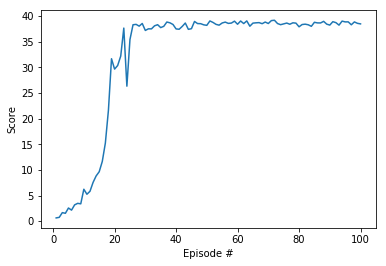

<Figure size 432x288 with 0 Axes>

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('learning-curve.jpg' , format='jpg')

In [19]:
env.close()

## 8. Conclusion

The DDPG agent is reaching the mean value of 30 per episode in ~ 20 episodes, and the environment is solved in the first 100 episodes, according to requirements